In [1]:
import datasets
from datasets import load_from_disk
import numpy as np
import os
import sys
parent_dir = os.path.join(os.getcwd(), '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility.data import HFDatasetWrapper

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import tabulate

import matplotlib.pyplot as plt


/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training size: 10, Dataset shape: (10, 8)
Accuracy for size 10: 0.7215
Training size: 50, Dataset shape: (50, 8)
Accuracy for size 50: 0.8953
Training size: 100, Dataset shape: (100, 8)
Accuracy for size 100: 0.9121
Training size: 200, Dataset shape: (200, 8)
Accuracy for size 200: 0.9101
Training size: 1000, Dataset shape: (1000, 8)
Accuracy for size 1000: 0.9131
Training size: 7872, Dataset shape: (7872, 8)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


Accuracy for size 7872: 0.9202
╒══════════════╤════════════╕
│   Train Size │   Accuracy │
╞══════════════╪════════════╡
│           10 │   0.721545 │
├──────────────┼────────────┤
│           50 │   0.895325 │
├──────────────┼────────────┤
│          100 │   0.912093 │
├──────────────┼────────────┤
│          200 │   0.910061 │
├──────────────┼────────────┤
│         1000 │   0.91311  │
├──────────────┼────────────┤
│         7872 │   0.920224 │
╘══════════════╧════════════╛


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


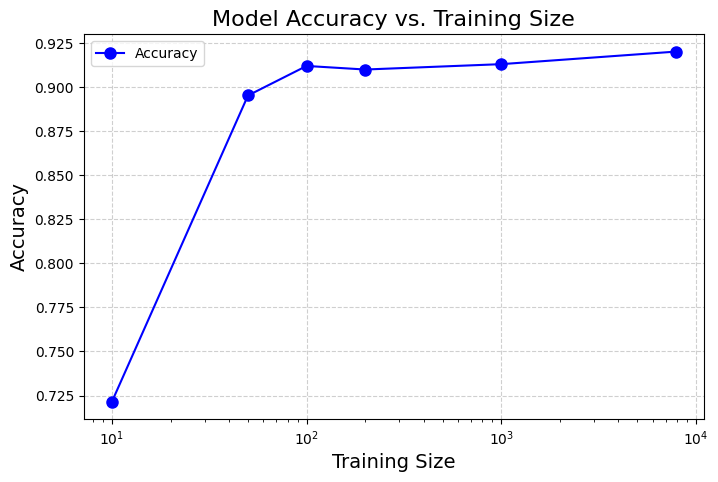

In [2]:
# Load dataset
full_dataset = load_from_disk('../data/full_dataset_new', keep_in_memory=True)

# Split dataset into training and testing (80% train, 20% test)
train_dataset, test_dataset = full_dataset.train_test_split(test_size=0.2).values()

# Get embeddings and labels for the test set
test_x = np.array(test_dataset['embedding'])  # Convert to numpy array
test_y = np.array(test_dataset['labels'])

# Define subset sizes
sizes = [10, 50, 100, 200, 1000, len(train_dataset)]

accuracy_list = {}
# Iterate over different training sizes
for size in sizes:
    # Shuffle the training dataset once per iteration
    train_dataset = train_dataset.shuffle(seed=42)
    subdataset = train_dataset.select(range(size))
    print(f"Training size: {size}, Dataset shape: {subdataset.shape}")

    # Extract features (X) and labels (y) for training
    train_x = np.array(subdataset['embedding'])
    train_y = np.array(subdataset['labels'])

    # Train the Random Forest classifier
    rf = RandomForestClassifier(max_samples=0.8, n_jobs=-1, random_state=42)
    rf.fit(train_x, train_y)

    # Make predictions
    predictions = rf.predict(test_x)

    # Compute accuracy
    accuracy = accuracy_score(test_y, predictions)
    print(f"Accuracy for size {size}: {accuracy:.4f}")
    accuracy_list.update({size: accuracy})

print(tabulate.tabulate([[size, arr] for size, arr in accuracy_list.items()], headers=["Train Size", "Accuracy"], tablefmt="fancy_grid"))

# Extract data for plotting
train_sizes = list(accuracy_list.keys())
accuracies = list(accuracy_list.values())

# Create plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, accuracies, marker='o', linestyle='-', color='b', markersize=8, label="Accuracy")

# Formatting
plt.xlabel("Training Size", fontsize=14, fontfamily="Times New Roman")
plt.ylabel("Accuracy", fontsize=14, fontfamily="Times New Roman")
plt.title("Model Accuracy vs. Training Size", fontsize=16, fontfamily="Times New Roman")
plt.xscale("log")  # If sizes vary widely, a log scale may be helpful
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# Show plot
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader

# Assume HFDatasetWrapper and train_dataset are already defined
# Define the number of classes in your dataset (change as needed)
num_classes = 10

# -------------------------
# Conditional Generator Definition
# -------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=10, num_classes=10, start_dim=128, n_layer=3, output_dim=512):
        super(Generator, self).__init__()
        # Embedding for condition (label)
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        # The input dimension becomes latent_dim + condition_dim
        input_dim = latent_dim + condition_dim
        
        layers = []
        # First layer: (latent_dim + condition_dim) -> start_dim
        layers.append(nn.Linear(input_dim, start_dim))
        layers.append(nn.ReLU(inplace=True))
        current_dim = start_dim
        # Build n_layer-1 hidden layers, doubling the dimension each time
        for i in range(1, n_layer):
            next_dim = current_dim * 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.BatchNorm1d(next_dim, momentum=0.8))
            layers.append(nn.ReLU(inplace=True))
            current_dim = next_dim
        # Final layer: current_dim -> output_dim
        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)
        
    def forward(self, z, labels):
        # Get label embeddings
        label_embedding = self.label_emb(labels)
        # Concatenate noise and label embeddings along the feature dimension
        x = torch.cat([z, label_embedding], dim=1)
        return self.model(x)

# -------------------------
# Conditional Discriminator Definition
# -------------------------
class Discriminator(nn.Module):
    def __init__(self, condition_dim=10, num_classes=10, start_dim=128, n_layer=3, input_dim=512):
        super(Discriminator, self).__init__()
        # Embedding for condition (label)
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        # The input dimension becomes data dimension + condition_dim
        input_dim = input_dim + condition_dim
        
        # Set initial hidden dimension to mirror the generator's last hidden layer
        hidden_dim = start_dim * (2 ** (n_layer - 1))
        
        layers = []
        # First layer: (input_dim + condition_dim already concatenated) -> hidden_dim
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        current_dim = hidden_dim
        # Build n_layer-1 hidden layers, each halving the dimension
        for i in range(1, n_layer):
            next_dim = current_dim // 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            current_dim = next_dim
        # Final layer: current_dim -> 1 (probability)
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, labels):
        # Get label embeddings
        label_embedding = self.label_emb(labels)
        # Concatenate input data and label embeddings
        x = torch.cat([x, label_embedding], dim=1)
        return self.model(x)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader

# Assume HFDatasetWrapper and train_dataset are already defined
# Define the number of classes in your dataset (change as needed)



# Create dataset and dataloader
dataset = HFDatasetWrapper(train_dataset)
data_loader = DataLoader(dataset, batch_size=32)

# Check a batch from the dataloader
batch = next(iter(data_loader))
print("Embedding shape:", batch['embedding'].shape)

# -------------------------
# Training Loop for Conditional GAN
# -------------------------
num_classes = 3
condition_dim = 10
latent_dim = 128
n_epochs = 5
device = torch.device("cpu")  # Change to "cuda" if using GPU
adversarial_loss = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator(
    latent_dim=latent_dim,
    condition_dim=condition_dim ,
    num_classes=num_classes,
    start_dim=latent_dim * 2,
    n_layer=3,
    output_dim=batch['embedding'].shape[-1]
)
discriminator = Discriminator(
    condition_dim=condition_dim ,
    num_classes=num_classes,
    start_dim=256,
    n_layer=3,
    input_dim=batch['embedding'].shape[-1]
)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Move models and loss to device
generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

# Training Loop
for epoch in range(n_epochs):
    d_avg_loss = 0.0
    g_avg_loss = 0.0
    for i, batch_dict in enumerate(tqdm(data_loader)):
        # Get real data and labels; ensure labels are of type Long for embedding lookup
        real_data = batch_dict['embedding'].to(device)
        labels = batch_dict['labels'].to(device).long()
        batch_size = real_data.size(0)
        
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)
        # Generate synthetic data conditioned on labels
        gen_data = generator(z, labels)
        g_loss = adversarial_loss(discriminator(gen_data, labels), valid)
        g_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_data, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_data.detach(), labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        g_avg_loss += g_loss.item() / len(data_loader)
        d_avg_loss += d_loss.item() / len(data_loader)
    
    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_avg_loss:.4f}] [G loss: {g_avg_loss:.4f}]")


Embedding shape: torch.Size([32, 768])


100%|██████████| 246/246 [00:05<00:00, 43.20it/s]


[Epoch 1/5] [D loss: 0.3225] [G loss: 2.4733]


100%|██████████| 246/246 [00:05<00:00, 45.90it/s]


[Epoch 2/5] [D loss: 0.3730] [G loss: 2.4421]


100%|██████████| 246/246 [00:05<00:00, 44.89it/s]


[Epoch 3/5] [D loss: 0.3940] [G loss: 2.1688]


100%|██████████| 246/246 [00:05<00:00, 45.48it/s]


[Epoch 4/5] [D loss: 0.4509] [G loss: 1.8397]


100%|██████████| 246/246 [00:05<00:00, 44.17it/s]

[Epoch 5/5] [D loss: 0.4616] [G loss: 1.7863]


In [5]:
generation_size = 1000
entailment_y = torch.ones(generation_size).long().to(device)
entailment = generator(torch.randn(generation_size, latent_dim, device=device), entailment_y).cpu().detach().numpy()
contradict_y = torch.zeros(generation_size).long().to(device)
contradict = generator(torch.randn(generation_size, latent_dim, device=device), contradict_y).cpu().detach().numpy()
combined_x = np.concatenate([entailment, contradict])
combined_y = np.concatenate([entailment_y.cpu().detach().numpy(), contradict_y.cpu().detach().numpy()])

Training size: 10, Dataset shape: (10, 8)
Accuracy before concatenation for size 10: 0.8648
Accuracy after concatenation for size 10: 0.8709
Training size: 50, Dataset shape: (50, 8)
Accuracy before concatenation for size 50: 0.8933
Accuracy after concatenation for size 50: 0.8933
Training size: 100, Dataset shape: (100, 8)
Accuracy before concatenation for size 100: 0.8984
Accuracy after concatenation for size 100: 0.8923
Training size: 200, Dataset shape: (200, 8)
Accuracy before concatenation for size 200: 0.8923
Accuracy after concatenation for size 200: 0.8918
Training size: 1000, Dataset shape: (1000, 8)
Accuracy before concatenation for size 1000: 0.8994
Accuracy after concatenation for size 1000: 0.9004
Training size: 7872, Dataset shape: (7872, 8)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


Accuracy before concatenation for size 7872: 0.9096
Accuracy after concatenation for size 7872: 0.9065
╒══════════════╤════════════════════════╤═══════════════════════╕
│   Train Size │   Before Concatenation │   After Concatenation │
╞══════════════╪════════════════════════╪═══════════════════════╡
│           10 │               0.864837 │              0.870935 │
├──────────────┼────────────────────────┼───────────────────────┤
│           50 │               0.893293 │              0.893293 │
├──────────────┼────────────────────────┼───────────────────────┤
│          100 │               0.898374 │              0.892276 │
├──────────────┼────────────────────────┼───────────────────────┤
│          200 │               0.892276 │              0.891768 │
├──────────────┼────────────────────────┼───────────────────────┤
│         1000 │               0.89939  │              0.900407 │
├──────────────┼────────────────────────┼───────────────────────┤
│         7872 │               0.909553

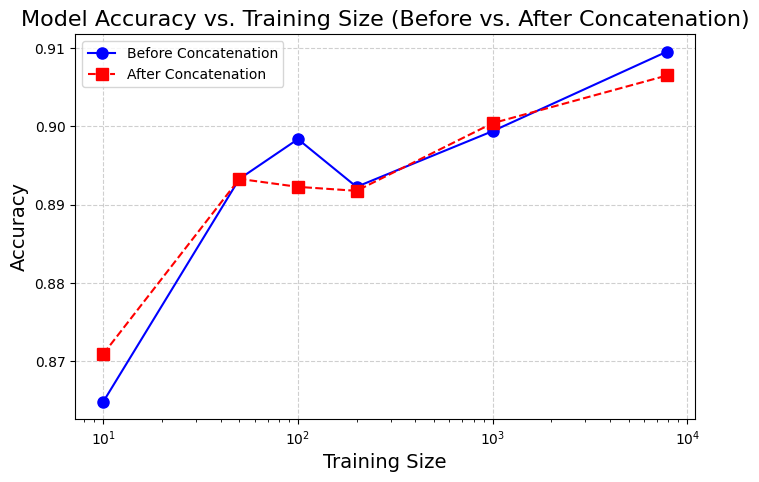

In [7]:
# Load dataset
full_dataset = load_from_disk('../data/full_dataset_new', keep_in_memory=True)

# Split dataset into training and testing (80% train, 20% test)
train_dataset, test_dataset = full_dataset.train_test_split(test_size=0.2).values()

# Get embeddings and labels for the test set
test_x = np.array(test_dataset['embedding'])  # Convert to numpy array
test_y = np.array(test_dataset['labels'])

# Define subset sizes
sizes = [10, 50, 100, 200, 1000, len(train_dataset)]

accuracy_before_concat = {}  # Stores accuracy before concatenation
accuracy_after_concat = {}   # Stores accuracy after concatenation

# Iterate over different training sizes
for size in sizes:
    # Shuffle dataset before selection
    train_dataset = train_dataset.shuffle(seed=42)
    subdataset = train_dataset.select(range(size))

    print(f"Training size: {size}, Dataset shape: {subdataset.shape}")

    # Extract features and labels
    train_x = np.array(subdataset['embedding'])
    train_y = np.array(subdataset['labels'])

    # Create additional synthetic data (example: adding Gaussian noise to existing data)
    synthetic_x = train_x + np.random.normal(0, 0.01, train_x.shape)  # Slightly altered copies
    synthetic_y = train_y  # Labels remain unchanged

    # Concatenate original and synthetic data
    train_combined_x = np.concatenate([train_x, synthetic_x])
    train_combined_y = np.concatenate([train_y, synthetic_y])

    # Train RandomForest before concatenation
    rf_before = RandomForestClassifier(max_samples=0.8, n_jobs=-1, random_state=42)
    rf_before.fit(train_x, train_y)
    pred_before = rf_before.predict(test_x)
    acc_before = accuracy_score(test_y, pred_before)
    accuracy_before_concat[size] = acc_before

    # Train RandomForest after concatenation
    rf_after = RandomForestClassifier(max_samples=0.8, n_jobs=-1, random_state=42)
    rf_after.fit(train_combined_x, train_combined_y)
    pred_after = rf_after.predict(test_x)
    acc_after = accuracy_score(test_y, pred_after)
    accuracy_after_concat[size] = acc_after

    print(f"Accuracy before concatenation for size {size}: {acc_before:.4f}")
    print(f"Accuracy after concatenation for size {size}: {acc_after:.4f}")

# Print results in table format
table_data = [[size, accuracy_before_concat[size], accuracy_after_concat[size]] for size in sizes]
print(tabulate.tabulate(table_data, headers=["Train Size", "Before Concatenation", "After Concatenation"], tablefmt="fancy_grid"))

# Extract data for plotting
train_sizes = list(accuracy_before_concat.keys())
accuracies_before = list(accuracy_before_concat.values())
accuracies_after = list(accuracy_after_concat.values())

# Create plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, accuracies_before, marker='o', linestyle='-', color='b', markersize=8, label="Before Concatenation")
plt.plot(train_sizes, accuracies_after, marker='s', linestyle='--', color='r', markersize=8, label="After Concatenation")

# Formatting
plt.xlabel("Training Size", fontsize=14, fontfamily="Times New Roman")
plt.ylabel("Accuracy", fontsize=14, fontfamily="Times New Roman")
plt.title("Model Accuracy vs. Training Size (Before vs. After Concatenation)", fontsize=16, fontfamily="Times New Roman")
plt.xscale("log")  # Log scale for better visualization
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# Show plot
plt.show()
